In [2]:
%reload_ext autoreload
%autoreload
%matplotlib inline

In [3]:
from fastai.text import *

In [4]:
from ranger import Ranger

In [5]:
# torch.cuda.empty_cache()

In [6]:
path = Path()
path.ls()

[PosixPath('__pycache__'),
 PosixPath('ttat.csv'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('tr_ch_tw_train.csv'),
 PosixPath('congressfinal.csv'),
 PosixPath('data_lm_export.pkl'),
 PosixPath('Senators'),
 PosixPath('Candidates'),
 PosixPath('final_china - output.csv'),
 PosixPath('Trump on Trade.ipynb'),
 PosixPath('Reps'),
 PosixPath('Filter Out Trump Negative Tweets.ipynb'),
 PosixPath('all_congress_tweets.csv'),
 PosixPath('models'),
 PosixPath('Tweets Descriptive Stats.ipynb'),
 PosixPath('data_clas_export.pkl'),
 PosixPath('US Congress on China and Trade.ipynb'),
 PosixPath('allsenatorsandrepsoutput.csv'),
 PosixPath('ranger.py')]

# Sentiment Model on China Using ULMFIT and Trump Tweets

In [7]:
df = pd.read_csv('ttat.csv',error_bad_lines=False)
df.head()

,sentiment,text,retweet_count
0,NaN,RT @ChatByCC: Strong people stand up for thems...,20709
1,NaN,The Media has a big responsibility to life and...,4749
2,NaN,We cannot let those killed in El Paso Texas an...,4687
3,NaN,....this legislation with desperately needed i...,4069
4,NaN,Today I authorized the lowering of the flags t...,20958


In [8]:
df.shape

(36989, 3)

In [9]:
bs=64

In [10]:
#Language Model DataBunch
data_lm = TextLMDataBunch.from_csv(path, 'ttat.csv', max_vocab=60000, min_freq=1)

In [11]:
data_lm.vocab.itos[:5]

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld']

In [12]:
data_lm.show_batch(3)

idx,text
0,tower to get out of a lease with xxmaj conde xxmaj nast ? xxbos xxmaj so impt xxmaj rep xxmaj senators under leadership of @senatemajldr mcconnell get healthcare plan approved . xxmaj after 7yrs of o'care disaster must happen ! xxbos @asadtmoosvi : @realdonaldtrump xxmaj what 's one advice you 'd give to an aspiring entrepreneur ? xxmaj work hard and love what you do - never give up !
1,"xxmaj trade xxmaj deals for our country ! xxbos i was recently asked if xxmaj crooked xxmaj hillary xxmaj clinton is going to run in 2020 ? xxmaj my answer was "" i hope so ! "" xxbos @malachino : xxmaj how will anybody beat xxmaj isis besides xxmaj trump . xxmaj they have never made a deal with another country xxmaj trump beats everyone all the time . xxbos"
2,run for xxup potus . xxbos @shoretntweet @realdonaldtrump did someone say # winewednesday ? xxmaj loved your winery in xxup va brought a case back to xxmaj pottstown xxup pa ! xxmaj great ! xxbos xxmaj what many people donâ€ ™ t understand or donâ€ ™ t want to understand is that xxmaj wayne xxmaj chris and the folks who work so hard at the xxup @nra are xxmaj great


In [13]:
# Classifier DataBunch
data_clas = TextClasDataBunch.from_csv(path, 'tr_ch_tw_train.csv', vocab=data_lm.train_ds.vocab, bs=8)

In [14]:
#Save both DataBunches
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

### Language Model

In [15]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                if N_sma > 5:                    
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                if N_sma > 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad, use_variance=True, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss

In [16]:
optar = partial(Ranger)

In [17]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, opt_func=optar)

In [18]:
learn.lr_find()

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


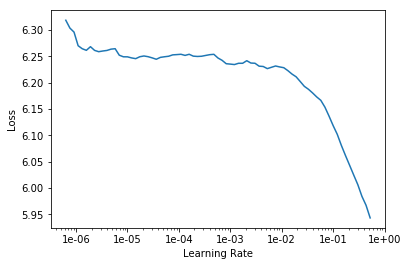

In [19]:
learn.recorder.plot(skip_end=15)

In [20]:
# Run one epoch with lower layers 
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.357477,4.024974,0.338010,01:15


In [21]:
# Run for many epochs with all layers unfrozen
learn.unfreeze()
learn.fit_one_cycle(10, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.844510,3.748893,0.363807,01:28
1,3.754455,3.715303,0.360992,01:29
2,3.659468,3.624239,0.375487,01:30
3,3.500682,3.720668,0.365374,01:30
4,3.346203,3.762767,0.361849,01:30
5,3.153604,3.708726,0.377310,01:30
6,2.860171,3.762497,0.380931,01:30
7,2.468771,3.858649,0.381674,01:30
8,2.063668,3.947896,0.384680,01:30
9,1.832424,4.011632,0.383878,01:30


In [22]:
learn.save_encoder('ft_enc')

### The Classifier

In [22]:
# #reload Databunches and Encoder
# data_lm = load_data(path, 'data_lm_export.pkl')
# data_clas = load_data(path, 'data_clas_export.pkl')

In [23]:
# load_encoder('ft_enc')

NameError: name 'load_encoder' is not defined

In [23]:
bs=8

In [24]:
# Classifier Learner Object
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.9, opt_func=optar) #opt_func=RAdam, 

In [25]:
learn.load_encoder('ft_enc')

In [26]:
data_clas.show_batch()

text,target
xxbos xxmaj president xxmaj xi of xxmaj china has been very helpful in his support of my meeting with xxmaj kim xxmaj jong xxmaj un . xxmaj the last thing xxmaj china wants are large scale nuclear weapons right next door . xxmaj sanctions placed on the border by xxmaj china and xxmaj russia have been very helpful . xxmaj great relationship with xxmaj chairman xxmaj kim !,positive
xxbos xxmaj china must continue to be strong and tight on the xxmaj border of xxmaj north xxmaj korea until a deal is made . xxmaj the word is that recently the xxmaj border has become much more porous and more has been filtering in . i want this to happen and xxmaj north xxmaj korea to be xxup very successful but only after signing !,positive
xxbos xxmaj president xxmaj xi and i will always be friends no matter what happens with our dispute on trade . xxmaj china will take down its xxmaj trade xxmaj barriers because it is the right thing to do . xxmaj taxes will become xxmaj reciprocal and a deal will be made on xxmaj intellectual xxmaj property . xxmaj great future for both countries !,positive
xxbos xxmaj one of the very exciting things to come out of my meeting with xxmaj president xxmaj xi of xxmaj china is his promise to me to criminalize the sale of deadly xxmaj fentanyl coming into the xxmaj united xxmaj states . xxmaj it will now be considered a “ controlled substance . ” xxmaj this could be a game changer on what is,positive
xxbos xxmaj chinese xxmaj president xxup xi xxup jinping and i spoke at length about the meeting with xxup kim xxup jong xxup un of xxmaj north xxmaj korea . xxmaj president xxup xi told me he appreciates that the xxup u.s. is working to solve the problem diplomatically rather than going with the ominous alternative . xxmaj china continues to be helpful !,positive


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


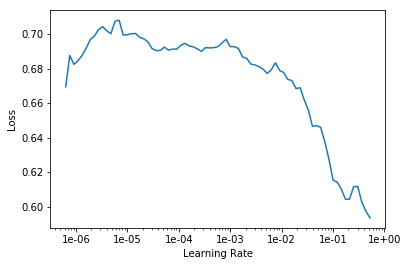

In [27]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [28]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.631202,0.511739,0.714286,00:00


In [29]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.417409,0.524674,0.714286,00:01


In [30]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.409585,0.469073,0.761905,00:01


In [33]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-8/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.364452,0.325216,0.904762,00:01
1,0.383814,0.328869,0.904762,00:01
2,0.399754,0.335804,0.952381,00:01
3,0.379170,0.325995,0.904762,00:01
4,0.394363,0.330504,0.952381,00:01
5,0.412844,0.329172,0.904762,00:01
6,0.395680,0.318639,0.952381,00:01
7,0.392081,0.317649,0.952381,00:01
8,0.400068,0.320788,0.904762,00:01
9,0.395891,0.324236,0.904762,00:01


# Preparing the Test Data

In [47]:
test = pd.read_csv(path/'all_congress_tweets.csv')
test.head(5)

,sentiment,Tweets,Likes,RTs,chamber,party
0,NaN,by adopting russian disinformation tactics dep...,535,173,house,democrats
1,NaN,the u.s. cannot lose its voice when human righ...,4553,997,house,democrats
2,NaN,the people of hong kong deserve to have their ...,363,80,house,democrats
3,NaN,words of world leaders can have dangerous cons...,4102,1376,house,democrats
4,NaN,"unfortunately, president trump has not only ce...",3524,922,house,democrats


In [ ]:
#change column width
# pd.options.display.max_colwidth = 50
# delete column
# df = df.drop("Unnamed: 0", axis=1)

In [48]:
test_pred = test

In [49]:
test_pred['sentiment'] = test_pred['Tweets'].apply(lambda row: str(learn.predict(row)[0]))
test_pred.head(40)

,sentiment,Tweets,Likes,RTs,chamber,party
0,negative,by adopting russian disinformation tactics dep...,535,173,house,democrats
1,negative,the u.s. cannot lose its voice when human righ...,4553,997,house,democrats
2,negative,the people of hong kong deserve to have their ...,363,80,house,democrats
3,negative,words of world leaders can have dangerous cons...,4102,1376,house,democrats
4,negative,"unfortunately, president trump has not only ce...",3524,922,house,democrats
5,negative,the ongoing trade war with china not only hurt...,46,16,house,democrats
6,positive,this directly hurts farmers in my district. as...,15,8,house,democrats
7,negative,soybean growers in tell me over over that they...,27,14,house,democrats
8,negative,"tomorrow, yet another round of retaliatory tar...",39,15,house,democrats
9,negative,☑️require the administration to develop an unc...,5,2,house,democrats


In [50]:
test_pred.shape

(4966, 6)

In [51]:
test_pred.to_csv('allsenatorsandrepsoutput.csv')